*Francisco Javier Sáez Maldonado*

# Ejercicio 1: Gambler's Ruin

Consideramos el problema *Gambler's Ruin*, en el que se pretende calcular el número medio de jugadas que tarda un jugador, que se encuentra en una casa de apuestas, en arruinarse apostando.  Podemos considerar para ello la siguiente cadena de Markov que representa nuestro problema:

![gamblers_ruin](gamblers_ruin.PNG)

Consideramos que:

- El estado (capital) inicial es el $m$ (que puede ser seleccionado por nosotros)
- En cada jugada se juega $1$ unidad de moneda
- El juego es equo, es decir, en este caso $p = q = 1/2$.

Se pretende estimar, repitiendo el experimento un número determinado de veces, la media y la varianza que tarda el jugador en arruinarse considerando un capital inicial de $1,\dots,50$ unidades.

Para esto, recordamos lo que queremos es estimar empíricamente el valor **teórico** del *first hitting time* de la posición $0$ de la cadena de Markov, es decir:

$$
H^0(\omega) = inf \{t \geq 0 \ | \ X_w(\omega) = 0\}.
$$

En este problema, se sabe que la probabilidad de arruinarse es 1, es decir: $h_n = \mathbb P_n(\text{hit } 0) = 1$. Por ello, queremos estudiar cuál es el tiempo medio $k_m$ de que esto ocurra. Vimos durantes las clases que este $h_n$ es $1$ puesa este problema proviene de (en virtud del **teorema 3.5** de los apuntes del profesor) encontrar la solución teórica al sistema de ecuaciones en recurrencia que en el caso general viene dado por:

$$
\begin{cases}
h_0 = 0 \\
h_m = p h_{m-1} + q h_{m+1} & m = 1,2,\dots
\end{cases}
$$

cuya solución teórica es justamente:

$$
h_n = 1 - A + A \left(\frac{q}{p}\right)^n.
$$

En nuestro caso particular donde  $ p = q = 1/2$, se tiene que $h_n = 1 + Bn$ y la condición $h_n \leq 1$ fuerza a que tengamos $B = 0$, lo que implica que $h_n = 1$, así que siempre nos acabaremos arruinando.

A la hora de **simular** esta cadena de Markov, tenemos que tener en cuenta la consideración de que puede haber casos en los que el jugador no se arruine nunca, porque se mantenga estable en una cantidad $k$ o porque vaya ascendiendo en esa cantidad debido al azar. Es por ello que establecemos un **máximo de iteraciones** en $10^5$.

Tras estas consideraciones, la simulación es sencilla: generar un número aleatorio, actualizar el estado a $m+1$ o $m-1$ según el número aleatorio generado, y repetir el proceso hasta que $m = 0$ o se alcance el número máximo de iteraciones. 

Creamos una clase `GambleMC` para encapsular el comportamiento del jugador.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from kalman_aux import *
from scipy.stats import multivariate_normal

np.random.seed(123)

In [2]:
RUIN = 0

class GamblerMC:
    
    
    def __init__(self, m, p = 0.5):
        self.ini_m = m
        self.curr_m = m
        self.p = p
        
    def _next(self):
        """
        Simulates a step in the Gambler's ruin MC
        """
        
        # Generate random uniform(0,1)
        gen = np.random.rand()
        
        # Update to m+1 with probability p and to m -1 with probability 1-p
        self.curr_m = self.curr_m + 1 if gen <= self.p else self.curr_m - 1
        
        return self.curr_m
    
    def simulation(self, max_iterations = 10**5):
        """
        Function that simulates the behaviour of the Gambler.
        Args:
            - max_iterations: maximum number of iterations that we simulate
        Return:
            - nº of plays if the gambler gets to be ruined
            - max_iterations If the gambler does not get to be ruined
        """
        if self.curr_m == RUIN:
            return 0
        
        for i in range(1,max_iterations+1):
            
            self._next()
            
            if self.curr_m == RUIN:
                self.curr_m = self.ini_m
                return i
            
            
        
        # Reset current m
        self.curr_m = self.ini_m
        
        return max_iterations
        


Con esta clase, podemos definir los diferentes estados iniciales que queremos obtener ( $m = 0,\dots,50$) y lanzar $100$ simulaciones del experimento por cada uno de esos estados. Entonces, calculamos su media y su varianza.

In [3]:
initial_m = np.arange(1,51,1)
n_simulations = 100
results = {}
for i in tqdm(initial_m):
    gambler = GamblerMC(m = i)
    res = [gambler.simulation() for j in range(n_simulations)]
    results[str(i)] = [np.mean(res),np.std(res)]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


In [4]:
def plot_average(results, regression = []):
    ys = np.array([results[str(i)][0] for i in initial_m])
    stds = np.array([results[str(i)][1] for i in initial_m])
    
    min_ys = ys - stds
    min_ys[min_ys < 0] = 0
    
    fig,ax = plt.subplots()
    ax.plot(initial_m,ys,label = "Average Iterations ")
    ax.fill_between(initial_m,min_ys,ys+stds,alpha = 0.2,label = "Standard deviation")
    ax.set_title("Average number of iterations of the Gambler's Ruin example")
    ax.set_xlabel("Initial m")
    ax.set_ylabel("Number of iterations")
    
    if len(regression) > 0:
        ax.plot(regression[0],regression[1], label = "Regression model")
    plt.legend(loc="upper left")
    plt.show()

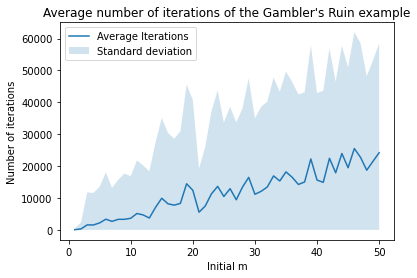

In [5]:
plot_average(results)

Como era de esperar, el número medio de iteraciones que tienen que darse para que el jugador se arruine crece cuando aumenta la cantidad inicial $m$. Esto es bastante lógico, pues ya de por sí la distancia a cero aumenta, y por tanto es menos probable que el jugador se arruine en pocas jugadas y pueda hacer crecer su capital para alejarse de la ruina. Como vemos, también la desviación típica es bastante grande, lo cual también tiene sentido pues tendremos iteraciones en las que el jugador no se arruine y difieran en cantidad de pasos hasta arruinarse bastante respecto a la media.

A continuación, se pide dar una **estimación** de la función $T(e)$, que da el **tiempo medio necesario para arruinarse** en función de la cantidad inicial de capital $e$.

Para ello, no tenemos otra opción que usar las medias obtenidas anteriormente y tratar de ajustar una recta mediante regresión lineal que minimice el error cuadrático medio a las medias anteriores. Esto es bastante sencillo de realizar utilizando `sklearn`.

In [6]:
X,y = initial_m.reshape(-1,1), [results[str(i)][0] for i in initial_m]

reg = LinearRegression()

reg.fit(X,y)

print("MSE for the linear model = {}".format(mean_squared_error(reg.predict(X),y)))
print("R2 score for the linear model = {}".format(r2_score(reg.predict(X),y)))

print("The model is: \n \t Y = ax + b = {} x + {}".format(reg.coef_[0],reg.intercept_))

MSE for the linear model = 5065038.824146578
R2 score for the linear model = 0.8863898989600999
The model is: 
 	 Y = ax + b = 462.6903174069627 x + -59.544293877548625


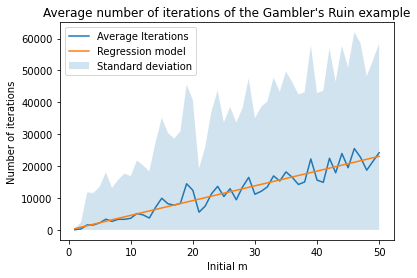

In [7]:
plot_average(results, [initial_m, reg.predict(X)])

Tras ajustar el modelo, la recta de regresión que obtenemos (mostrada también en la salida por consola) es 

$$
Y = 462.6903174069627 x + -59.5442938775486.
$$

Se muestran también el el error cuadrático medio y el coeficiente $R^2$. Aunque el error cuadrático medio pueda parecer muy alto, esto es debido a que los residuos son bastante grandes y estamos trabajando con valores muy grandes, como podemos observar en el eje $y$. El coeficiente $R^2$ nos indica que estamos explicando gran parte de la variabilidad de los datos con nuestro modelo (recordamos que $0 \leq R^2 \leq 1$, por lo que aceptamos este modelo lineal.

Por último, se nos pide que realicemos una predicción utilizando $e = 200$. Podemos hacerlo prediciendo con nuestro modelo lineal.

In [8]:
value = np.array([200]).reshape(-1,1)
print("Prediction for e = 200: {}".format(reg.predict(value)[0]))

Prediction for e = 200: 92478.51918751499


Se obtiene que el número medio es bastante cercano a $10^5$, por lo que concluimos que con $e = 200$, en la mayoría de ocasiones el jugador no ha llegado a arruinarse aún (recordemos que el número máximo de pasos que se pueden dar es $10^5$).

# Ejercicio 2

Crear cuatro sistemas dinámicos del tipo:

$$
\begin{cases}
x_{t+1} = \mathbf{A} x_t + \mathbf{B}u_t + w_t\\
z_t = \mathbf{C}x_t v_t
\end{cases}
$$

con $x_i \in \mathbb R^4$, $u_t \in \mathbb R$, $z_t \in \mathbb R^2$ y,

$$
\mathbf{B} = \left[1,1,1,1\right]'
$$

$$
\mathbf{C} = \begin{bmatrix} 1,0,0,0 \\ 0,1,0,0 \end{bmatrix}
$$

Estos sistemas se distinguen por la matriz $\mathbf A$, que es, por cada sistema una de las matrices generadas usando la función `mk_mat` (que podemos encontrar en el fichero `kalman_aux.py`), a partir de las siguientes listas de autovalores:
$$
\Lambda_1 = [ 0.2, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_2 = [ 0.99, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_3 = [ 1.0, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_4 = [ 0.2, 0.1, 0.0, -1.0 ]
$$

Los ruidos $w_t \in \mathbb R^4$ y $v_t \in \mathbb R^2$ son gausianos y tienen matrices de covarianza
$$
\mathbf Q = \sigma_w^2 \mathbf I_4
$$
$$
\mathbf R = \sigma_v^2 \mathbf I_2
$$

siendo $\mathbf I_n$ la matriz identidad de orden $n$.

El fichero `kalman_aux.py` define las matrices $\mathbf{ B,C,Q,R}$ y proporcional la función `mk_mat` para crear la matriz $\mathbf A$ dada la matriz de autovalores.

**Nota.-** La matriz $\mathbf A$ tiene autovectores generados de forma aleatoria, por lo que cada llamada a la función con los mismos autovalores generará matrices diferentes con esos autovalores.

**Nota Importante.-** Realizamos una pequeña modificación en el archivo `kalman_aux.py` para que las funciones dadas por el profesor devuelvan arrays de `numpy`. Esto nos facilitará hacer las cuentas de forma eficiente en adelante. 

Vamos a crear las matrices $\mathbf A$ para los diferentes vectores de valores propios dados:

In [9]:
Lambda_1 = [ 0.2, 0.1, 0.0, -0.1 ]
Lambda_2 = [ 0.99, 0.1, 0.0, -0.1 ]
Lambda_3 = [ 1.0, 0.1, 0.0, -0.1 ]
Lambda_4 = [ 0.2, 0.1, 0.0, -1.0 ]

Lambdas = [Lambda_1, Lambda_2, Lambda_3, Lambda_4]

As = [mk_mat(Lambda) for Lambda in Lambdas]

## Apartado b

Ahora, por cada uno de los sistemas generados, vamos a crear un filtro de Kalman para estimar el estado del sistema en cada instante de tiempo. Para ello, queremos usar como *input* la función
$$
u(t) = \begin{cases} 0 & t \leq 50 \\ 1 & t > 50\end{cases}
$$
Esta función también viene implementada en el archivo dado por el profesor. 

Se pide que se haga la simulación usando $t = 0,\dots,99$ y que se dibuje un gráfico del error relativo
$$
e(t) = \sum_{k=1}^t \frac{\lvert \lvert \hat x_k - x_k \rvert \rvert ^2}{\lvert \lvert x_k \lvert \lvert^2}
$$

Para ello, vamos a comenzar realizando una clase que nos encapsule el comportamiento de un filtro de Kalman dadas las matrices $\mathbf{A,B}$ y $\mathbf C$ y una función de input.

In [10]:
class DynamicalSystem:
    
    def __init__(self, A, B, C, f_input):
        self.A = A
        self.B = B
        self.C = C
        self.f_input = f_input
        self.w = multivariate_normal(None, Q, allow_singular = True)
        self.v = multivariate_normal(None, R, allow_singular = True)
        
    def Kalman_Gain(self, P):
        """
        Computes the Kalman Gain 
        Arguments:
            - P: P_t matrix
        """
        return P @ self.C.T @ np.linalg.inv( self.C @ P @ self.C.T + R)      
        
    def real_values(self, max_t, x_0, bar_P):
        """
        Simulate the dynamical system to obtain the real values x_t
        Arguments:
            - max_time: Maximum number of iterations
            - x_0: initial value for x
            - bar_P: initial value for bar P
        """
        
        xs = [x_0]
        for t in range(1, max_t):
            xs.append( self.A @ xs[t-1] + self.B * self.f_input(t-1) + self.w.rvs() )
        

        return np.array(xs)
    
    def kalman_simulation(self, max_t, x_0, bar_P, actual_xs = []):
        """
        Simulates the system using a Kalman filter
        Arguments:
            - max_time: Maximum number of iterations
            - x_0: initial value for x
            - bar_P: initial value for bar P
        """
        
        xs = actual_xs if len(actual_xs) > 0 else self.real_values(max_t,x_0,bar_P)
        
        estimations = [x_0]
        
        x_prior = x_0
        bar_P = bar_P
        
        for t in range(1,max_t):
            
            # Compute Kalman Gain
            K_t = self.Kalman_Gain(bar_P)
            
            # Update estimation
            z_t = self.C @ xs[t] + self.v.rvs()
            estimate = x_prior + K_t @ ( z_t - self.C @ x_prior )
            
            # Update covariance
            P = (np.identity(bar_P.shape[0]) - K_t @ self.C) @ bar_P
            
            # Update prior estimations 
            x_prior = self.A @ estimate + self.B * self.f_input(t)
            bar_P = self.A @ P @ self.A.T + Q
        
            # Save elements
            estimations.append(estimate)
            
        return np.array(estimations)
        
        

In [11]:
def error(true,pred):
    vector = np.array([np.linalg.norm(x-y)**2 / np.linalg.norm(y)**2 for x,y in zip(pred,true)])
    return np.cumsum(vector)

def experiment(matrices, max_t, n_runs = 100):
    
    results = []
    
    # Obtain results of the experiments
    for i,matrix in tqdm(enumerate(matrices)):
        n = matrix.shape[0]
        x_0 = np.zeros(n)
        P0 = sigma_w * np.identity(n)
        
        system = DynamicalSystem(matrices[i],B,C,u_f)
        
        matrix_results = []
        
        for j in range(n_runs):
            true_vals = system.real_values(max_t, x_0, P0)
            kalman_vals = system.kalman_simulation(max_t,x_0,P0, true_vals)
            # Skip the first one since it is zero in both cases.
            matrix_results.append(error(true_vals[1:],kalman_vals[1:]))

        # Obtain mean and variance of all the iterations
        matrix_results = np.array([np.mean(matrix_results,axis = 0), np.std(matrix_results,axis = 0)])
        results.append(matrix_results)
        
    return np.array(results)

In [12]:

results = experiment(As, max_t = 100,  n_runs = 100)


4it [00:08,  2.21s/it]


In [13]:
def plot_errors(results,names, max_t):
    
    xs = np.arange(1,max_t,1)
    
    fig,ax = plt.subplots(2,2,figsize = (14,12))
    
    
    for k in range(results.shape[0]):
        i = int(k/2)
        j = k%2
        
        ax[i,j].plot(xs, results[k][0], label = "Relative error" )
        ax[i,j].fill_between(xs, results[k][0] - results[k][1], results[k][0] + results[k][1], alpha = 0.2,label = "+- Std")
        ax[i,j].axvline(x = max_t/2,color = "green",label = "input change")
    
        ax[i,j].set_xlabel("Time")
        ax[i,j].set_ylabel("Relative error")
        ax[i,j].legend(loc = "upper left")
        
        
        ax[i,j].set_title(names[k])
    
    plt.legend(loc="upper left")
    plt.show()
    
    
    

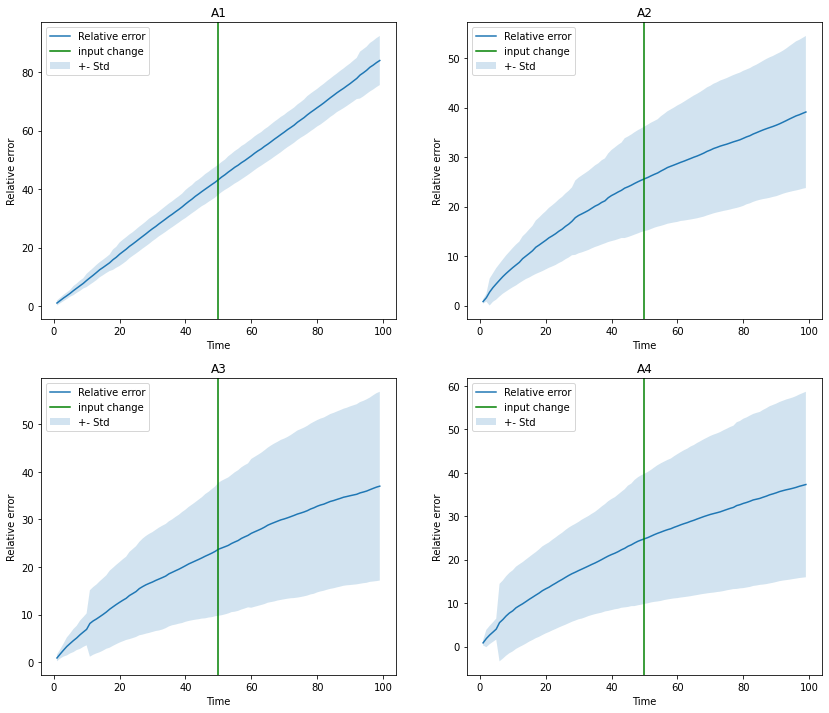

In [14]:
names = ["A1", "A2", "A3", "A4"]
plot_errors(results,names,max_t = 100)